# Exercises 1 Answers

## Exercise 1.1

In [8]:
# From https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
import math

import torch
import numpy as np
import matplotlib.pyplot as plt


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'

In [9]:
def polynomial_fit_pytorch(x):
    y = torch.exp(x)

    model = Polynomial3()

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the nn.Linear
    # module which is members of the model.
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

    for t in range(8000):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        if t % 400 == 399:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

399 1704.4620361328125
799 739.9332885742188
1199 548.8504638671875
1599 510.6435241699219
1999 502.9189758300781
2399 501.3368835449219
2799 501.0079650878906
3199 500.93853759765625
3599 500.923583984375
3999 500.9202575683594
4399 500.9195556640625
4799 500.9193420410156
5199 500.9193115234375
5599 500.91925048828125
5999 500.91925048828125
6399 500.9193420410156
6799 500.9193420410156
7199 500.9193420410156
7599 500.9193420410156
7999 500.9193420410156
Result: y = 0.50007164478302 + 0.7393174767494202 x + 0.965630292892456 x^2 + 0.281513512134552 x^3


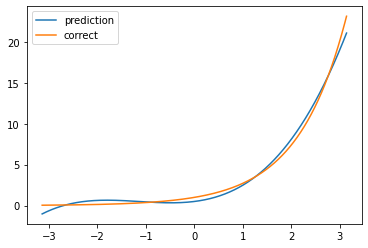

In [10]:
# Run this to test your code

def show_result():
    print(f'Result: y = {model.a.item()} + {model.b.item()} x + {model.c.item()} x^2 + {model.d.item()} x^3')
    x_data = np.linspace(-math.pi, math.pi, 2000)
    y_data = model.a.item() + model.b.item()*x_data + model.c.item()*np.power(x_data,2) + model.d.item()*np.power(x_data,3)
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label='prediction')
    ax.plot(x_data, np.exp(x_data), label='correct')
    ax.legend()
    plt.show()
    
model = polynomial_fit_pytorch(torch.linspace(-math.pi, math.pi, 2000))
show_result()
np.testing.assert_allclose((model.a.item(),model.b.item(),model.c.item(),model.d.item()), (0.500051380635291, 0.7393321213180061, 0.9656340560418195, 0.28151141256621487), rtol=1e-1)